# Accuracy Comparison

In [ ]:
# libraries
from lib.experiments.accuracy import plot_accuracy_analysis
 
dataset_name = 'compas-binary'
plot_accuracy_analysis(dataset_name, 'Test Accuracy vs Tree Width ({})'.format(dataset_name))

# Scalability Comparison

In [ ]:
from mpl_toolkits import mplot3d

from lib.data_structures.dataset import read_dataframe
from lib.experiments.scalability import plot_scalability_analysis

dataset_name = 'compas-binary'
timeout = 60

# dataset_name = 'census_c1s5ky0.2_0_0_test'
# timeout = 20

# Scalablity Analysis for CART
dataset = read_dataframe('data/scalability/{}/{}.csv'.format(dataset_name, 'cart'))
plot_scalability_analysis(dataset, 'CART Scalability', z_limit=timeout)

# Scalablity Analysis for OSDT
dataset = read_dataframe('data/scalability/{}/{}.csv'.format(dataset_name, 'osdt'))
plot_scalability_analysis(dataset, 'OSDT Scalability', z_limit=timeout)

# Scalablity Analysis for Parallel OSDT
# for core_count in [1, 2, 4, 8, 16, 32, 60]:
for core_count in [1, 2]:
    dataset = read_dataframe('data/scalability/{}/parallel_osdt_{}_core.csv'.format(dataset_name, core_count))
    plot_scalability_analysis(dataset, 'Parallel OSDT Scalability ({} Clients, 1 Server)'.format(core_count), z_limit=timeout)

# Convergence Rate

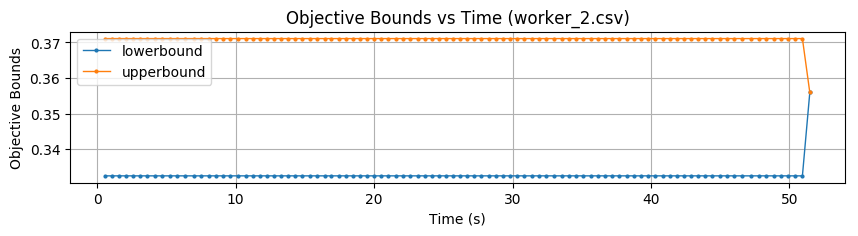

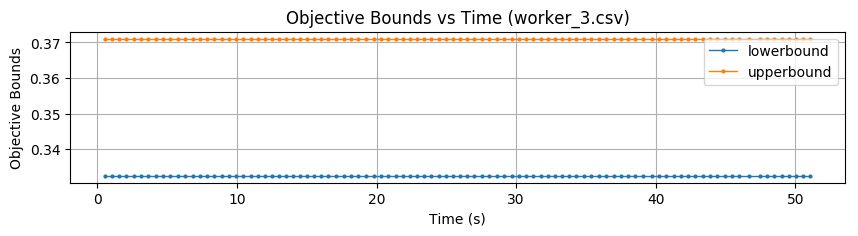

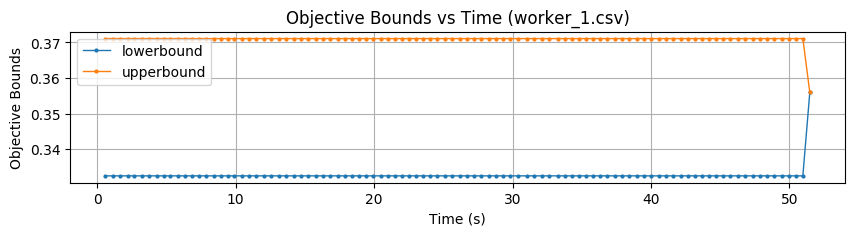

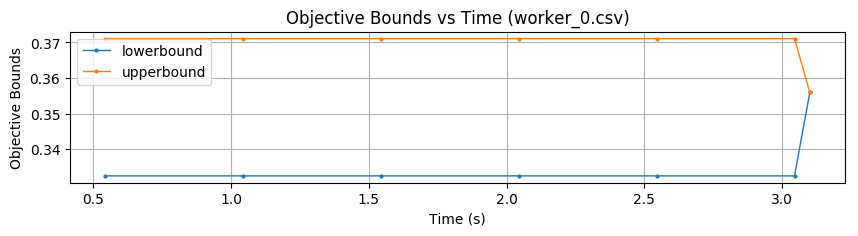

In [8]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

from lib.data_structures.dataset import read_dataframe

directory = 'data/convergence'
paths = [
    join(directory, name)
    for name in listdir(directory)
    if isfile(join(directory, name))]

for path in paths:
    dataset = read_dataframe(path)
    (n, m) = dataset.shape

    x = dataset.values[:,0]
    y1 = dataset.values[:,1]
    y2 = dataset.values[:,2]

    fig = plt.figure(figsize=(10, 2), dpi=100)
    plt.plot(x, y1, label='lowerbound', markersize=2, marker='o', linewidth=1)
    plt.plot(x, y2, label='upperbound', markersize=2, marker='o', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Objective Bounds')
    plt.grid()
    plt.legend()
    plt.title('Objective Bounds vs Time ({})'.format(basename(path)))

# Work Distribution Profile

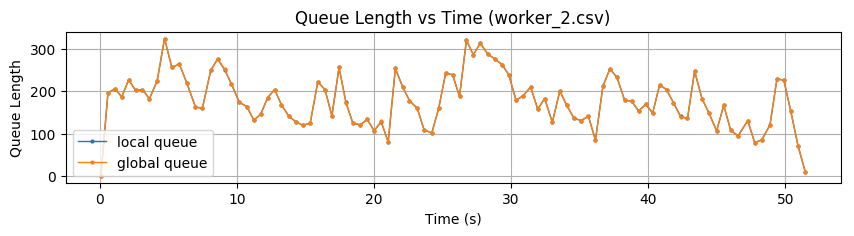

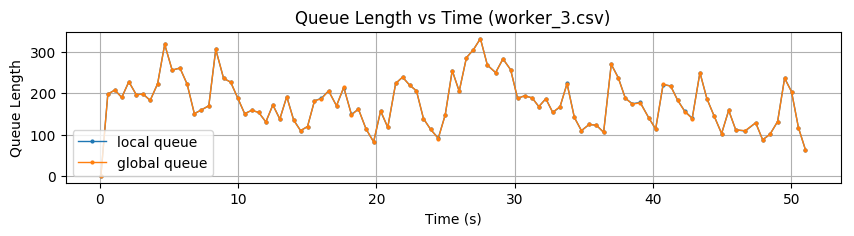

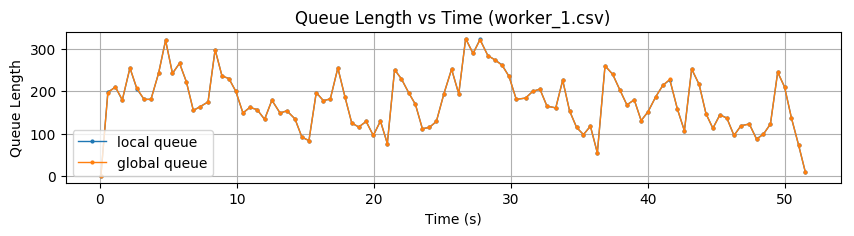

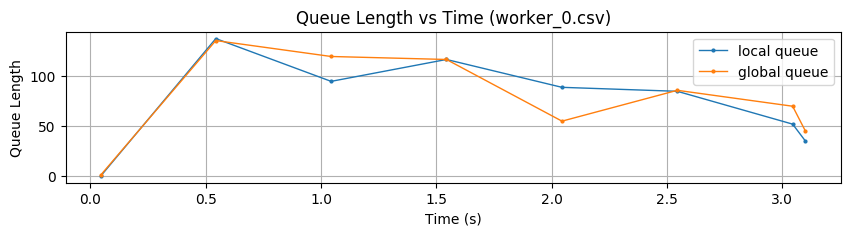

In [9]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, basename

from lib.data_structures.dataset import read_dataframe

directory = 'data/distribution'
paths = [
    join(directory, name)
    for name in listdir(directory)
    if isfile(join(directory, name))]

for path in paths:
    dataset = read_dataframe(path)
    (n, m) = dataset.shape

    x = dataset.values[:,0]
    y1 = dataset.values[:,1]
    y2 = dataset.values[:,2]

    fig = plt.figure(figsize=(10, 2), dpi=100)
    plt.plot(x, y1, label='local queue', markersize=2, marker='o', linewidth=1)
    plt.plot(x, y2, label='global queue', markersize=2, marker='o', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Queue Length')
    plt.grid()
    plt.legend()
    plt.title('Queue Length vs Time ({})'.format(basename(path)))

# Memory Profile

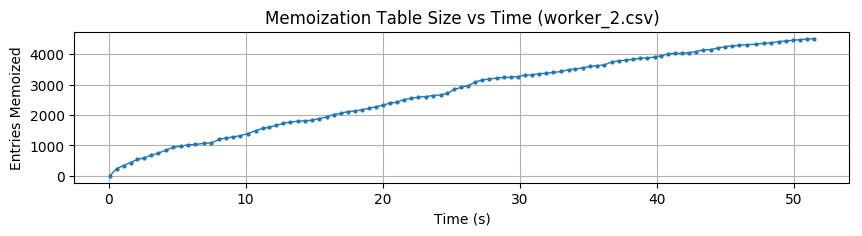

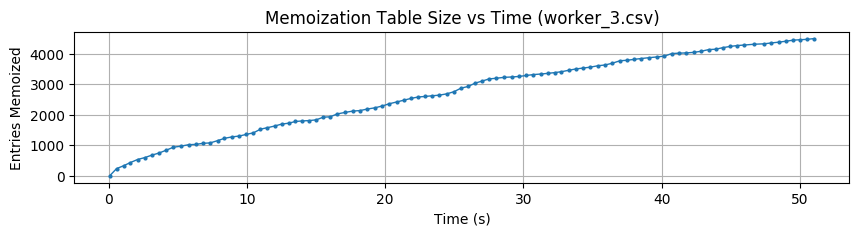

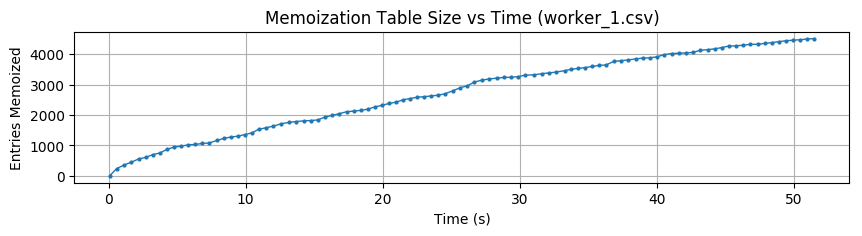

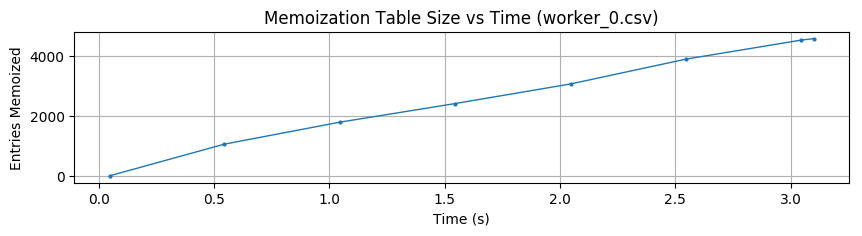

In [10]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, basename

from lib.data_structures.dataset import read_dataframe

directory = 'data/memory'
paths = [
    join(directory, name)
    for name in listdir(directory)
    if isfile(join(directory, name))]

for path in paths:
    dataset = read_dataframe(path)
    (n, m) = dataset.shape

    x = dataset.values[:,0]
    y = dataset.values[:,1]

    fig = plt.figure(figsize=(10, 2), dpi=100)
    plt.plot(x, y, markersize=2, marker='o', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Entries Memoized')
    plt.grid()
    plt.title('Memoization Table Size vs Time ({})'.format(basename(path)))

# Runtime Profile

In [ ]:
import cProfile

# local imports
from lib.models.parallel_osdt_classifier import ParallelOSDTClassifier
from lib.data_structures.dataset import read_dataframe

# Using COMPAS as an example
dataset = read_dataframe('data/preprocessed/census.csv') 
(n, m) = dataset.shape
X = dataset.values[:n,:-1]
y = dataset.values[:n,-1]

hyperparameters = {
    'regularization': 0.2, # Regularization coefficient which effects the penalty on model complexity

    'max_depth': float('Inf'), # User-specified limit on the model
    'max_time': float('Inf'), # User-specified limit on the runtime 

    'workers': 1, # Parameter that varies based on how much computational resource is available

    'visualize_model': False, # Toggle whether a rule-list visualization is rendered
    'visualize_training': False,  # Toggle whether a dependency graph is streamed at runtime
    'verbose': False, # Toggle whether event messages are printed
    'log': False, # Toggle whether client processes log to logs/work_<id>.log files
    
    'configuration': { # More configurations around toggling optimizations and prioritization options
        'priority_metric': 'uncertainty', # Decides how tasks are prioritized
        'deprioritization': 0.01, # Decides how much to push back a task if it has pending dependencies

        # Note that Leaf Permutation Bound (Theorem 6) is 
        # Toggles the assumption about objective independence when composing subtrees (Theorem 1)
        # Disabling this actually breaks convergence due to information loss
        'hierarchical_lowerbound': True, 
        # Toggles whether problems are pruned based on insufficient accuracy (compared to other results) (Lemma 2)
        'look_ahead': True,
        # Toggles whether a split is avoided based on insufficient support (proxy for accuracy gain) (Theorem 3)
        'support_lowerbound': True,
        # Toggles whether a split is avoided based on insufficient potential accuracy gain (Theorem 4)
        'incremental_accuracy_lowerbound': True,
        # Toggles whether a problem is pruned based on insufficient accuracy (in general) (Theorem 5)
        'accuracy_lowerbound': True,
        # Toggles whether problem equivalence is based solely on the capture set (Similar to Corollary 6)
        'capture_equivalence': True,
        # Hamming distance used to propagate bounding information of similar problems (Theorem 7 + some more...)
        "similarity_threshold": 0,
        # Toggles whether equivalent points contribute to the lowerbound (Proposition 8 and Theorem 9)
        'equivalent_point_lowerbound': True,

        # Toggles compression of dataset based on equivalent point aggregation
        'equivalent_point_compression': False,
        # Toggles whether asynchronous tasks can be cancelled after being issued
        'task_cancellation': True,
        # Toggles whether look_ahead prunes using objective upperbounds (This builds on top of look_ahead)
        'interval_look_ahead': True,
        # Cooldown timer (seconds) on synchornization operations
        'synchronization_cooldown': 0.01
    }
}

model = ParallelOSDTClassifier(**hyperparameters)
model.fit(X, y)
cProfile.run('model.fit(X, y)', sort='tottime')

# Iris Experiment

In [ ]:
# third-party imports
from time import time

# local imports
from lib.models.parallel_osdt_classifier import ParallelOSDTClassifier
from lib.data_structures.dataset import read_dataframe

# Using COMPAS as an example
dataset = read_dataframe('data/preprocessed/iris.csv') 
(n, m) = dataset.shape

m = 58 # Use only sepal features

X = dataset.values[:n,:m]
y = dataset.values[:n,-3] # Select first vs other for label

hyperparameters = {
    'regularization': 0.01, # Regularization coefficient which effects the penalty on model complexity

    'max_depth': float('Inf'), # User-specified limit on the model
    'max_time': float('Inf'), # User-specified limit on the runtime 

    'workers': 1, # Parameter that varies based on how much computational resource is available

    'visualize_model': True, # Toggle whether a rule-list visualization is rendered
    'visualize_training': False,  # Toggle whether a dependency graph is streamed at runtime
    'verbose': False, # Toggle whether event messages are printed
    'log': False, # Toggle whether client processes log to logs/work_<id>.log files
    'profile': False, # Toggle Snapshots for Profiling Memory Usage
    
    'configuration': { # More configurations around toggling optimizations and prioritization options
        'priority_metric': 'uniform', # Decides how tasks are prioritized
        'deprioritization': 0.01, # Decides how much to push back a task if it has pending dependencies

        # Note that Leaf Permutation Bound (Theorem 6) is 
        # Toggles the assumption about objective independence when composing subtrees (Theorem 1)
        # Disabling this actually breaks convergence due to information loss
        'hierarchical_lowerbound': True, 
        # Toggles whether problems are pruned based on insufficient accuracy (compared to other results) (Lemma 2)
        'look_ahead': True,
        # Toggles whether a split is avoided based on insufficient support (proxy for accuracy gain) (Theorem 3)
        'support_lowerbound': True,
        # Toggles whether a split is avoided based on insufficient potential accuracy gain (Theorem 4)
        'incremental_accuracy_lowerbound': True,
        # Toggles whether a problem is pruned based on insufficient accuracy (in general) (Theorem 5)
        'accuracy_lowerbound': True,
        # Toggles whether problem equivalence is based solely on the capture set (Similar to Corollary 6)
        'capture_equivalence': True,
        # Hamming distance used to propagate bounding information of similar problems (Theorem 7 + some more...)
        "similarity_threshold": 0,
        # Toggles whether equivalent points contribute to the lowerbound (Proposition 8 and Theorem 9)
        'equivalent_point_lowerbound': True,

        # Toggles compression of dataset based on equivalent point aggregation
        'equivalent_point_compression': False,
        # Toggles whether asynchronous tasks can be cancelled after being issued
        'task_cancellation': True,
        # Toggles whether look_ahead prunes using objective upperbounds (This builds on top of look_ahead)
        'interval_look_ahead': True,
        # Cooldown timer (seconds) on synchornization operations
        'synchronization_cooldown': 0.01,
        # Cache Limit
        'independence': 0.5
    }
}

start = time()
model = ParallelOSDTClassifier(**hyperparameters)
model.fit(X, y)
prediction = model.predict(X)
# prediction = prediction.reshape(1, n)
print('Runtime: {} Seconds'.format(time() - start))
print('Prediction: \n{}'.format(prediction))
print('Training Accuracy: {}'.format(model.score(X, y)))
print('Visualization: \n{}'.format(model.model.visualization))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

""" 
	Desc: 	1. sepal-length
			2. sepal-width
			3. petal-length
			4. petal-width
			5. classification 
				- Iris-setosa
				- Iris-versicolor
				- Iris-virginica
"""

# Plot Truth

dataset = read_dataframe('data/iris/iris.csv')
(n,m) = dataset.shape
lengths = dataset.values[:,:-1]
flower_type = dataset.values[:,-1]

for i in range(n):
	x, y = [lengths[i,0], lengths[i,1]]
	scale = 100.0
	# determine color
	flower = flower_type[i]
	color = ""
	if flower == "Iris-setosa":
		color = "red"
	elif flower == "Iris-versicolor":
		color = "blue"
	elif flower == "Iris-virginica":
		color = "blue"

	plt.scatter(x, y, s=scale, c=color, alpha=1, edgecolor="none")

# Legend
red_patch = mpatches.Patch(color='red', label='iris setosa')
green_patch = mpatches.Patch(color='blue', label='iris versicolor')
blue_patch = mpatches.Patch(color='blue', label='iris virginica')
plt.legend(handles=[red_patch, green_patch, blue_patch])

plt.title("The Iris Data Set (Ground Truth)", fontsize=18)
plt.xlabel('petal length', fontsize=15)
plt.ylabel('petal width', fontsize=15)

plt.grid(True)

plt.show()

# Plot Predictions

for i in range(n):
	x, y = [lengths[i,0], lengths[i,1]]
	scale = 100.0
	# determine color
	prediction[i]
	color = ""
	if prediction[i,0] == 0:
		color = "blue"
	elif prediction[i,0] == 1:
		color = "red"

	plt.scatter(x, y, s=scale, c=color, alpha=1, edgecolor="none")

# Legend
red_patch = mpatches.Patch(color='red', label='iris setosa')
green_patch = mpatches.Patch(color='blue', label='iris versicolor')
blue_patch = mpatches.Patch(color='blue', label='iris virginica')
plt.legend(handles=[red_patch, green_patch, blue_patch])

plt.title("The Iris Data Set (Predictions)", fontsize=18)
plt.xlabel('petal length', fontsize=15)
plt.ylabel('petal width', fontsize=15)

plt.grid(True)

plt.show()






In [ ]:

length_domain = np.arange(4,8,0.1)
width_domain = np.arange(2,4.5,0.1)

X = []

for l in length_domain:
    for w in width_domain:
        row = [0,0,l,w]
        X.append(row)

y = x.reshape(-1, 1)
h = x * y
print(h)

cs = plt.contourf(h, levels=[10, 30, 50],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

